In [20]:
import pandas as pd
import seaborn as sns
import os
os.chdir("/Users/rodrigoestebanantoniopizarroschwerter/projects/resto-ds-rappiflow/dags/analytics")

from utils.get_snowflake_data import SnowflakeConnector

In [21]:
conn = SnowflakeConnector()

In [22]:
var_mz_query = """
   WITH 
    -- Auxiliar table to make the relation between city and microzone
    MICROZONE_CITY as (
        SELECT  MZ.ID MICROZONE_ID,
            MZ.NAME MICROZONE,
            CA.CITY,
            MZ.CITY_ID
        FROM MX_GRABILITY_PUBLIC.MICRO_ZONES_VW MZ
        LEFT JOIN MX_PGLR_MS_COUNTRY_DATA_PUBLIC.CITY_ADDRESSES CA ON CA.ID = MZ.CITY_ID  
        WHERE 1=1
            AND COALESCE(FALSE,MZ._FIVETRAN_DELETED) = FALSE

    )
    -- Get bad experience scores for a store at level city in the last 6 months.
    , GLOBAL_SCORES AS (
        SELECT 
        'MX' as COUNTRY,
        o.microzone_name,
        MZC.CITY,
        O.BRAND_ID,
        O.STORE_ID,
        COUNT(DISTINCT O.ORDER_ID) GLOBAL_STORE_ORDERS,
        COUNT(DISTINCT CASE WHEN UBE.ORDER_ID IS NOT NULL THEN UBE.ORDER_ID ELSE NULL END) AS GLOBAL_BAD_EXPERIENCE_ORDER,
        GLOBAL_BAD_EXPERIENCE_ORDER/GLOBAL_STORE_ORDERS GLOBAL_BAD_EXPERIENCE_SCORE
        FROM GLOBAL_FINANCES.MX_ORDERS O
        LEFT JOIN MICROZONE_CITY MZC ON MZC.MICROZONE_ID = O.MICROZONE_ID AND MZC.MICROZONE = O.MICROZONE_NAME 
        LEFT JOIN cl_writable.bad_experiences_orders_v8_mx  UBE ON O.ORDER_ID = UBE.ORDER_ID 
                                        AND UBE.COUNTRY = 'MX' 
                                        AND UBE.CREATED_AT::DATE between dateadd('month',-9,current_date) and dateadd('month',-3,current_date)
        WHERE 1=1 
        AND O.CREATED_AT::DATE between dateadd('month',-9,current_date) and dateadd('month',-3,current_date)
        AND O.ORDER_STATE NOT IN 
            ('canceled_for_payment_error', 
            'canceled_by_fraud', 
            'canceled_by_split_error',
            'canceled_by_early_regret')
        AND MZC.CITY IS NOT NULL
        GROUP BY 1,2,3,4,5
        HAVING GLOBAL_STORE_ORDERS > 100
    )
    , MIN_MAX_DIFF AS (
        SELECT
            COUNTRY,
            CITY,
            BRAND_ID,
            STORE_ID,
            AVG(GLOBAL_BAD_EXPERIENCE_SCORE) MZ_AVG_BES,
            MIN(GLOBAL_BAD_EXPERIENCE_SCORE) MZ_MIN_BES,
            MAX(GLOBAL_BAD_EXPERIENCE_SCORE) MZ_MAX_BES,
            MZ_MAX_BES-MZ_MIN_BES MIN_MAX_DIFF
        FROM GLOBAL_SCORES
        GROUP BY 1,2,3,4
    )
        
        SELECT *
        FROM MIN_MAX_DIFF
"""

In [23]:
var_mz = conn.get_pandas_dataframe_from_query(var_mz_query)

Amount of Nulls:
 Empty DataFrame
Columns: [COLUMN, AMOUNT_OF_NULLS, PERC_OF_NULLS]
Index: []


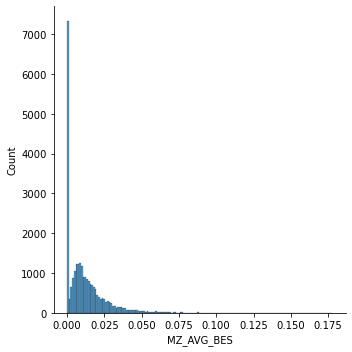

In [26]:
sns.displot(var_mz['MZ_AVG_BES'])

In [24]:
var_franja_query = """
   WITH 
    -- Auxiliar table to make the relation between city and microzone
    MICROZONE_CITY as (
        SELECT  MZ.ID MICROZONE_ID,
            MZ.NAME MICROZONE,
            CA.CITY,
            MZ.CITY_ID
        FROM MX_GRABILITY_PUBLIC.MICRO_ZONES_VW MZ
        LEFT JOIN MX_PGLR_MS_COUNTRY_DATA_PUBLIC.CITY_ADDRESSES CA ON CA.ID = MZ.CITY_ID  
        WHERE 1=1
            AND COALESCE(FALSE,MZ._FIVETRAN_DELETED) = FALSE

    )
    -- Get bad experience scores for a store at level city in the last 6 months.
    , GLOBAL_SCORES AS (
        SELECT 
        'MX' as COUNTRY,
        case when time(o.created_at) between '05:00:00' and '11:00:00' then 'breakfast'
           when time(o.created_at) between '11:00:01' and '15:00:00' then 'noon'
           when time(o.created_at) between '15:00:01' and '18:00:00' then 'afternoon'
        else 'night' end moment,
        MZC.CITY,
        O.BRAND_ID,
        O.STORE_ID,
        COUNT(DISTINCT O.ORDER_ID) GLOBAL_STORE_ORDERS,
        COUNT(DISTINCT CASE WHEN UBE.ORDER_ID IS NOT NULL THEN UBE.ORDER_ID ELSE NULL END) AS GLOBAL_BAD_EXPERIENCE_ORDER,
        GLOBAL_BAD_EXPERIENCE_ORDER/GLOBAL_STORE_ORDERS GLOBAL_BAD_EXPERIENCE_SCORE
        FROM GLOBAL_FINANCES.MX_ORDERS O
        LEFT JOIN MICROZONE_CITY MZC ON MZC.MICROZONE_ID = O.MICROZONE_ID AND MZC.MICROZONE = O.MICROZONE_NAME 
        LEFT JOIN cl_writable.bad_experiences_orders_v8_mx  UBE ON O.ORDER_ID = UBE.ORDER_ID 
                                        AND UBE.COUNTRY = 'MX' 
                                        AND UBE.CREATED_AT::DATE between dateadd('month',-9,current_date) and dateadd('month',-3,current_date)
        WHERE 1=1 
        AND O.CREATED_AT::DATE between dateadd('month',-9,current_date) and dateadd('month',-3,current_date)
        AND O.ORDER_STATE NOT IN 
            ('canceled_for_payment_error', 
            'canceled_by_fraud', 
            'canceled_by_split_error',
            'canceled_by_early_regret')
        AND MZC.CITY IS NOT NULL
        GROUP BY 1,2,3,4,5
        HAVING GLOBAL_STORE_ORDERS > 100
    )
    , MIN_MAX_DIFF AS (
        SELECT
            COUNTRY,
            CITY,
            BRAND_ID,
            STORE_ID,
            AVG(GLOBAL_BAD_EXPERIENCE_SCORE) FRANJA_AVG_BES,
            MIN(GLOBAL_BAD_EXPERIENCE_SCORE) FRANJA_MIN_BES,
            MAX(GLOBAL_BAD_EXPERIENCE_SCORE) FRANJA_MAX_BES,
            FRANJA_MAX_BES-FRANJA_MIN_BES MIN_MAX_DIFF
        FROM GLOBAL_SCORES
        GROUP BY 1,2,3,4
    )
        
     select *
     from MIN_MAX_DIFF

"""

In [25]:
var_franja = conn.get_pandas_dataframe_from_query(var_franja_query)

Amount of Nulls:
 Empty DataFrame
Columns: [COLUMN, AMOUNT_OF_NULLS, PERC_OF_NULLS]
Index: []


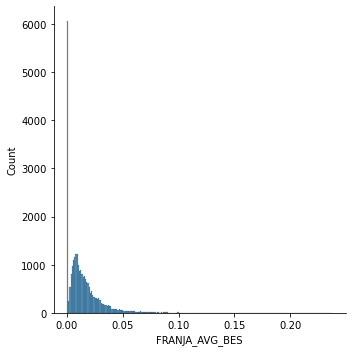

In [30]:
sns.displot(var_franja['FRANJA_AVG_BES'])